In [1]:
!pip install DeepMIMO==2

Defaulting to user installation because normal site-packages is not writeable


In [27]:
###### Deep Learning Coordinated Beamforming with DeepMIMO #################
# Author: Umut Demirhan, Ahmed Alkhateeb
# Date: March 19, 2022 
# Paper: A. Alkhateeb, S. Alex, P. Varkey, Y. Li, Q. Qu and D. Tujkovic, 
# "Deep Learning Coordinated Beamforming for Highly-Mobile Millimeter Wave 
# Systems," in IEEE Access, vol. 6, pp. 37328-37348, 2018.
###########################################################################

import DeepMIMO
import os
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from tqdm import tqdm
from scipy.io import loadmat, savemat 
import glob
import re 

plt.rcParams['figure.figsize'] = [12, 8] # Set default plot size



In [2]:
def beamforming_codebook(ant_shape = np.array([1, 32, 1]), oversampling_rate = np.array([1, 1, 1]), kd = 0.5):
    
    kd = 2 * np.pi * kd
    codebook_size = ant_shape * oversampling_rate
    
    vecs = []
    for dim in range(3):
        ind = np.arange(ant_shape[dim]).reshape((-1, 1))
        codebook_ang = np.linspace(0, np.pi, codebook_size[dim], endpoint = False).reshape((1, -1))                                                                                                     
        vec = np.sqrt(1./ant_shape[dim]) * np.exp(-1j * kd * ind * np.cos(codebook_ang))
        vecs.append(vec)
        
    F = np.kron(vecs[2], np.kron(vecs[1], vecs[0]))
    
    return F
    
   

In [3]:
#%% # Generate the dataset
# # Load and print the default parameters
parameters = DeepMIMO.default_params()


# # Change parameters for the setup
# Scenario O1_60 extracted at the dataset_folder
parameters['scenario'] = 'O1_60'
parameters['dataset_folder'] = '' # Set DeepMIMO dataset folder that has O1_60

parameters['num_paths'] = 5

# User rows 1-100
parameters['user_row_first'] = 1000
parameters['user_row_last'] = 1050

# Activate only the first basestation
#parameters['active_BS'] = np.array([3, 4, 5, 6]) 

parameters['active_BS'] = np.array([3, 4]) 


parameters['OFDM']['bandwidth'] = 0.5 # 50 MHz
parameters['OFDM']['subcarriers'] = 1024 # OFDM with 512 subcarriers
parameters['OFDM']['subcarriers_limit'] = 64 # Keep only first 64 subcarriers

parameters['enable_BS2BS'] = False

parameters['ue_antenna']['shape'] = np.array([1, 1, 1]) # Single antenna
parameters['bs_antenna']['shape'] = np.array([1, 32, 8]) # ULA of 32 elements
parameters['bs_antenna']['radiation_pattern'] = 'halfwave-dipole'
parameters['ue_antenna']['radiation_pattern'] = 'halfwave-dipole'
pprint(parameters)

{'OFDM': {'RX_filter': 0,
          'bandwidth': 0.5,
          'subcarriers': 1024,
          'subcarriers_limit': 64,
          'subcarriers_sampling': 1},
 'OFDM_channels': 1,
 'active_BS': array([3, 4]),
 'bs_antenna': {'radiation_pattern': 'halfwave-dipole',
                'shape': array([ 1, 32,  8]),
                'spacing': 0.5},
 'dataset_folder': '',
 'dynamic_settings': {'first_scene': 1, 'last_scene': 1},
 'enable_BS2BS': False,
 'num_paths': 5,
 'row_subsampling': 1,
 'scenario': 'O1_60',
 'ue_antenna': {'radiation_pattern': 'halfwave-dipole',
                'shape': array([1, 1, 1]),
                'spacing': 0.5},
 'user_row_first': 1000,
 'user_row_last': 1050,
 'user_subsampling': 1}


In [4]:
dataset = DeepMIMO.generate_data(parameters)
print(len(dataset))


Basestation 3

UE-BS Channels


Generating channels: 100%|██████████| 9231/9231 [00:05<00:00, 1551.63it/s]



Basestation 4

UE-BS Channels


Generating channels: 100%|██████████| 9231/9231 [00:05<00:00, 1700.41it/s]

2


In [5]:
#%% Parameters and Codebook
num_bs = len(parameters['active_BS'])
num_ue = len(parameters['active_UE'])
F = beamforming_codebook(ant_shape = parameters['bs_antenna'][0]['shape'], oversampling_rate = np.array([1, 2, 1]), kd = parameters['bs_antenna'][0]['spacing'])

num_OFDM = int(parameters['OFDM']['subcarriers_limit']/parameters['OFDM']['subcarriers_sampling'])
num_beams = F.shape[1]
num_bs = len(parameters['active_BS'])
num_ue = len(parameters['active_UE'])



NF = 5             # Noise figure at the base station
Process_Gain = 10  # Channel estimation processing gain
BW = parameters['OFDM']['bandwidth'] * 1e9 # System bandwidth in Hz
noise_power_dB = -204 + 10*np.log10(BW/parameters['OFDM']['subcarriers']) + NF - Process_Gain; # Noise power in dB
noise_power = 10**(.1*(noise_power_dB)); # Noise power

#%% DL Input-Output
input_norm = np.zeros((num_bs, num_ue, num_OFDM), dtype=complex)
max_rates = np.zeros((num_bs, num_ue, num_beams))


In [7]:
print(dataset)

[{'user': {'paths': array([{'num_paths': 4, 'DoD_phi': array([ 47.182 ,  47.182 , -93.2287, -93.2287], dtype=float32), 'DoD_theta': array([111.451 , 125.271 ,  91.1165,  92.2321], dtype=float32), 'DoA_phi': array([-132.818 , -132.818 ,  -96.7162,  -96.7162], dtype=float32), 'DoA_theta': array([ 68.5488, 125.271 ,  88.8835,  92.2321], dtype=float32), 'phase': array([  86.2506, -123.668 , -108.747 ,  -78.2853], dtype=float32), 'ToA': array([3.64960e-08, 4.16052e-08, 6.84996e-07, 6.85386e-07], dtype=float32), 'power': array([1.2743550e-09, 4.0392464e-12, 1.6493029e-14, 6.7654919e-15],
             dtype=float32)}                                                                                                                                                                                                                                                                                                                                                                                               

In [8]:
#for bs_idx in tqdm(range(num_bs), desc='Neural Network Input-Output Generation-BS', position=0, leave=True):

for bs_idx in tqdm(range(num_bs), desc='Neural Network Input-Output Generation-BS', position=0, leave=True):
    for ue_idx in tqdm(range(num_ue), desc='Neural Network Input-Output Generation-BS-%i'%bs_idx, position=0, leave=True):
        # print(dataset[bs_idx]['user']['channel'].shape)
        ch = dataset[bs_idx]['user']['channel'][ue_idx].squeeze()
        ch = ch + np.sqrt(noise_power) * (np.random.randn(*(ch.shape)) + 1j * np.random.randn(*(ch.shape)))
        input_norm[bs_idx, ue_idx, :] = ch[0, :]
        max_rates[bs_idx, ue_idx, :] = np.sum(np.log2(1 + np.abs(ch.T.conj() @ F)**2),  axis = 0)/num_OFDM
        

Neural Network Input-Output Generation-BS: 100%|██████████| 2/2 [1:07:37<00:00, 2028.58s/it]


In [9]:
# Input reshape - normalize
input_norm = np.transpose(input_norm, axes=[1, 0, 2])
input_norm = input_norm.reshape((num_ue, -1))
input_norm /=  np.amax(np.abs(input_norm))

# Output reshape - normalize
max_rates_norm_factor = np.amax(max_rates, axis=2, keepdims=True)
max_rates_norm_factor[max_rates_norm_factor== 0] = 1 # Do not normalize if all zeros
max_rates /= max_rates_norm_factor
max_rates = np.transpose(max_rates, axes=[1, 0, 2])
max_rates = max_rates.reshape((num_ue, -1))

if not os.path.exists('./DLCB_dataset'):
                      os.makedirs('DLCB_dataset')
savemat('./DLCB_dataset/DLCB_input.mat', {'DL_input': input_norm})
savemat('./DLCB_dataset/DLCB_output.mat', {'DL_output': max_rates})


In [21]:
# %% Machine Learning
import os
import keras
import keras.models as models
from keras.layers import Dense,Dropout, LeakyReLU
import numpy as np
from tensorflow.keras.layers import LayerNormalization, Activation
from tensorflow.keras.optimizers import AdamW

# Model training function
def train(In_train, Out_train, In_test, Out_test,
          epochs, batch_size,dr,
          num_hidden_layers, nodes_per_layer,
          loss_fn,n_BS,n_beams):
    
    in_shp = list(In_train.shape[1:])

    AP_models = []
    for bs_idx in range(n_BS):
        idx_str = 'BS%i' % bs_idx
        idx = bs_idx*n_beams
        
        model = models.Sequential()
        model.add(Dense(nodes_per_layer, activation='relu', kernel_initializer='he_normal', input_shape=in_shp))
        # model.add(LayerNormalization())
        # model.add(Activation('relu'))
        model.add(Dropout(dr))
        for h in range(num_hidden_layers):
            model.add(Dense(nodes_per_layer, activation='relu', kernel_initializer='he_normal'))
            model.add(Dropout(dr))
        
        model.add(Dense(n_beams, kernel_initializer='he_normal', name="dense" + idx_str + "o"))
        model.add(LeakyReLU(alpha=0.01))
        optimizer = AdamW(learning_rate=5e-3)
        model.compile(loss=loss_fn, optimizer=optimizer) # Baseline optimizer='adamW' was goated
        model.summary()

        print(Out_train[:, idx:idx + n_beams].shape)
        model.fit(In_train,
                    Out_train[:, idx:idx + n_beams],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(In_test, Out_test[:,idx:idx + n_beams]),
                    callbacks = [
                        #keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
                    ])
        
        AP_models.append(model)
        
        
    return AP_models


In [22]:
# # %% Machine Learning
# import os
# import keras
# import keras.models as models
# from keras.layers import Dense,Dropout
# import numpy as np
# from tensorflow.keras.layers import BatchNormalization, Activation

# # Model training function
# def train(In_train, Out_train, In_test, Out_test,
#           epochs, batch_size,dr,
#           num_hidden_layers, nodes_per_layer,
#           loss_fn,n_BS,n_beams):
    
#     in_shp = list(In_train.shape[1:])

#     AP_models = []
#     for bs_idx in range(n_BS):
#         idx_str = 'BS%i' % bs_idx
#         idx = bs_idx*n_beams
        
#         model = models.Sequential()
#         model.add(Dense(nodes_per_layer, activation='relu', kernel_initializer='he_normal', input_shape=in_shp))
#         model.add(Dropout(dr))
#         for h in range(num_hidden_layers):
#             model.add(Dense(nodes_per_layer, activation='relu', kernel_initializer='he_normal'))
#             model.add(Dropout(dr))
        
#         model.add(Dense(n_beams, activation='relu', kernel_initializer='he_normal',
#                   name="dense" + idx_str + "o"))
#         model.compile(loss=loss_fn, optimizer='adam')
#         model.summary()

#         print(Out_train[:, idx:idx + n_beams].shape)
#         model.fit(In_train,
#                     Out_train[:, idx:idx + n_beams],
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=2,
#                     validation_data=(In_test, Out_test[:,idx:idx + n_beams]),
#                     callbacks = [
#                         #keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
#                         keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
#                     ])
        
#         AP_models.append(model)
        
        
#     return AP_models


In [23]:
In_set_file=loadmat('DLCB_dataset/DLCB_input.mat')
Out_set_file=loadmat('DLCB_dataset/DLCB_output.mat')
print(In_set_file['DL_input'])

[[ 0.02059918+0.79159118j  0.10892574+0.83027043j  0.21535616+0.76127791j
  ...  0.19555415+0.04808605j  0.17789301-0.06935876j
   0.14633113-0.14283165j]
 [-0.2669831 -0.7555762j  -0.35636871-0.7263186j  -0.44298984-0.6432961j
  ... -0.27284991-0.12484509j -0.31171022+0.02209109j
  -0.23228987+0.18052336j]
 [-0.16516854-0.78892367j -0.25209302-0.78149505j -0.33088558-0.72298008j
  ...  0.22519188-0.26752048j  0.05892798-0.33981923j
  -0.10930934-0.35134095j]
 ...
 [-0.33571318+0.03986729j -0.26876928+0.17705177j -0.14334707+0.30347578j
  ... -0.14118353+0.36019338j -0.08505925+0.38335713j
   0.03600327+0.42152932j]
 [-0.15005275-0.11581114j -0.15573165-0.05785696j -0.1730542 +0.00433674j
  ...  0.30894293-0.26936158j  0.24426467-0.32808194j
   0.17196516-0.37263138j]
 [-0.21156059-0.07252863j -0.20999956+0.0636365j  -0.1760332 +0.14732168j
  ...  0.26683844+0.33873332j  0.29340587+0.27412139j
   0.34588413+0.22136413j]]


In [24]:
# Reading input and output sets generated from MATLAB
In_set_file=loadmat('DLCB_dataset/DLCB_input.mat')
Out_set_file=loadmat('DLCB_dataset/DLCB_output.mat')

In_set=In_set_file['DL_input']
Out_set=Out_set_file['DL_output']

# Parameter initialization
num_user_tot=In_set.shape[0]
n_DL_size=[0.001, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7]
count=0
num_tot_TX=2
num_beams=512

for DL_size_ratio in n_DL_size:
    
    print (DL_size_ratio)
    count=count+1
    DL_size=int(num_user_tot*DL_size_ratio)
    
    np.random.seed(2016)
    n_examples = DL_size
    num_train  = int(DL_size * 0.8)
    num_test   = int(num_user_tot*.2)
    
    train_index = np.random.choice(range(0,num_user_tot), size=num_train, replace=False)
    rem_index = set(range(0,num_user_tot))-set(train_index)
    test_index= list(set(np.random.choice(list(rem_index), size=num_test, replace=False)))
    
    In_train = In_set[train_index]
    In_test =  In_set[test_index] 
        
    Out_train = Out_set[train_index]
    Out_test = Out_set[test_index]
    
    
    # Learning model parameters
    epochs = 12     
    batch_size = 70  
    dr = 0.05                  # dropout rate  
    num_hidden_layers=4
    nodes_per_layer=In_train.shape[1]
    loss_fn='mean_squared_error'
    
    # Model training
    AP_models = train(In_train, Out_train, In_test, Out_test,
                                          epochs, batch_size,dr,
                                          num_hidden_layers, nodes_per_layer,
                                          loss_fn,num_tot_TX,num_beams)

    
    # Model running/testing
    DL_Result={}
    for idx in range(0,num_tot_TX,1): 
        beams_predicted=AP_models[idx].predict( In_test, batch_size=10, verbose=0)
    
        DL_Result['TX'+str(idx+1)+'Pred_Beams']=beams_predicted
        DL_Result['TX'+str(idx+1)+'Opt_Beams']=Out_test[:,idx*num_beams:(idx+1)*num_beams]

    DL_Result['user_index']=test_index
    
    
    if not os.path.exists('./DLCB_code_output'):
                          os.makedirs('DLCB_code_output')
    savemat('DLCB_code_output/DL_Result'+str(count)+'.mat',DL_Result)

0.001


Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_450 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_450 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_451 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_451 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_452 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_452 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_453 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_453 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_454 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_454 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_240 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(7, 512)
Epoch 1/12
1/1 - 6s - 6s/step - loss: 0.1234 - val_loss: 0.0129
Epoch 2/12
1/1 - 0s - 205ms/step - loss: 0.0121 - val_loss: 0.0063
Epoch 3/12
1/1 - 0s - 196ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 4/12
1/1 - 0s - 207ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 5/12
1/1 - 0s - 224ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 6/12
1/1 - 0s - 225ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 7/12
1/1 - 0s - 204ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 8/12
1/1 - 0s - 195ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 9/12
1/1 - 0s - 191ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 10/12
1/1 - 0s - 181ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 11/12
1/1 - 0s - 216ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 12/12
1/1 - 0s - 221ms/step - loss: 0.0022 - val_loss: 0.0029


Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_455 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_455 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_456 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_456 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_457 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_457 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_458 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_458 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_459 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_459 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_241 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(7, 512)
Epoch 1/12
1/1 - 6s - 6s/step - loss: 0.0950 - val_loss: 0.0152
Epoch 2/12
1/1 - 0s - 206ms/step - loss: 0.0125 - val_loss: 0.0064
Epoch 3/12
1/1 - 0s - 217ms/step - loss: 0.0073 - val_loss: 0.0042
Epoch 4/12
1/1 - 0s - 202ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 5/12
1/1 - 0s - 341ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 6/12
1/1 - 0s - 255ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 7/12
1/1 - 0s - 203ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/12
1/1 - 0s - 202ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 9/12
1/1 - 0s - 210ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 10/12
1/1 - 0s - 194ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 11/12
1/1 - 0s - 196ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 12/12
1/1 - 0s - 194ms/step - loss: 0.0025 - val_loss: 0.0028
0.05


Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_460 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_460 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_461 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_461 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_462 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_462 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_463 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_463 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_464 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_464 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_242 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(368, 512)
Epoch 1/12
6/6 - 9s - 1s/step - loss: 0.0157 - val_loss: 0.0028
Epoch 2/12
6/6 - 0s - 43ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 3/12
6/6 - 0s - 37ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 4/12
6/6 - 0s - 42ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 5/12
6/6 - 0s - 39ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 6/12
6/6 - 0s - 37ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 7/12
6/6 - 0s - 36ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/12
6/6 - 0s - 36ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 9/12
6/6 - 0s - 37ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 10/12
6/6 - 0s - 35ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 11/12
6/6 - 0s - 35ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 12/12
6/6 - 0s - 51ms/step - loss: 0.0023 - val_loss: 0.0024


Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_465 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_465 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_466 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_466 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_467 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_467 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_468 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_468 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_469 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_469 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_243 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(368, 512)
Epoch 1/12
6/6 - 8s - 1s/step - loss: 0.0326 - val_loss: 0.0028
Epoch 2/12
6/6 - 0s - 40ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 3/12
6/6 - 0s - 41ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 4/12
6/6 - 0s - 37ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 5/12
6/6 - 0s - 38ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 6/12
6/6 - 0s - 38ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 7/12
6/6 - 0s - 36ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 8/12
6/6 - 0s - 37ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 9/12
6/6 - 0s - 38ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 10/12
6/6 - 0s - 32ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 11/12
6/6 - 0s - 34ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 12/12
6/6 - 0s - 34ms/step - loss: 0.0023 - val_loss: 0.0023
0.1


Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_470 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_470 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_471 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_471 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_472 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_472 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_473 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_473 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_474 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_474 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_244 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(738, 512)
Epoch 1/12
11/11 - 9s - 783ms/step - loss: 0.0185 - val_loss: 0.0028
Epoch 2/12
11/11 - 0s - 25ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 3/12
11/11 - 0s - 21ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 4/12
11/11 - 0s - 25ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 5/12
11/11 - 0s - 20ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 6/12
11/11 - 0s - 21ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 7/12
11/11 - 0s - 20ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 8/12
11/11 - 0s - 22ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/12
11/11 - 0s - 21ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/12
11/11 - 0s - 22ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 11/12
11/11 - 0s - 21ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 12/12
11/11 - 0s - 21ms/step - loss: 0.0022 - val_loss: 0.0022


Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_475 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_475 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_476 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_476 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_477 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_477 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_478 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_478 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_479 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_479 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_245 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(738, 512)
Epoch 1/12
11/11 - 8s - 739ms/step - loss: 0.0129 - val_loss: 0.0026
Epoch 2/12
11/11 - 0s - 21ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 3/12
11/11 - 0s - 22ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 4/12
11/11 - 0s - 22ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 5/12
11/11 - 0s - 21ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/12
11/11 - 0s - 21ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/12
11/11 - 0s - 24ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 8/12
11/11 - 0s - 19ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/12
11/11 - 0s - 22ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/12
11/11 - 0s - 20ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 11/12
11/11 - 0s - 22ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 12/12
11/11 - 0s - 21ms/step - loss: 0.0021 - val_loss: 0.0021
0.15


Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_480 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_480 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_481 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_481 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_482 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_482 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_483 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_483 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_484 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_484 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_246 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(1107, 512)
Epoch 1/12
16/16 - 9s - 534ms/step - loss: 0.0108 - val_loss: 0.0027
Epoch 2/12
16/16 - 0s - 15ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 3/12
16/16 - 0s - 15ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 4/12
16/16 - 0s - 15ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 5/12
16/16 - 0s - 14ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 6/12
16/16 - 0s - 17ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 7/12
16/16 - 0s - 15ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 8/12
16/16 - 0s - 16ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/12
16/16 - 0s - 15ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/12
16/16 - 0s - 15ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 11/12
16/16 - 0s - 15ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 12/12
16/16 - 0s - 15ms/step - loss: 0.0021 - val_loss: 0.0021


Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_485 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_485 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_486 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_486 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_487 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_487 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_488 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_488 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_489 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_489 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_247 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(1107, 512)
Epoch 1/12
16/16 - 8s - 507ms/step - loss: 0.0096 - val_loss: 0.0026
Epoch 2/12
16/16 - 0s - 15ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 3/12
16/16 - 0s - 17ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 4/12
16/16 - 0s - 16ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 5/12
16/16 - 0s - 14ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/12
16/16 - 0s - 13ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 7/12
16/16 - 0s - 15ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 8/12
16/16 - 0s - 13ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 9/12
16/16 - 0s - 14ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 10/12
16/16 - 0s - 14ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 11/12
16/16 - 0s - 13ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 12/12
16/16 - 0s - 15ms/step - loss: 0.0018 - val_loss: 0.0020
0.2


Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_490 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_490 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_491 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_491 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_492 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_492 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_493 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_493 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_494 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_494 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_248 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(1476, 512)
Epoch 1/12
22/22 - 8s - 376ms/step - loss: 0.0061 - val_loss: 0.0026
Epoch 2/12
22/22 - 0s - 12ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 3/12
22/22 - 0s - 12ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 4/12
22/22 - 0s - 12ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 5/12
22/22 - 0s - 12ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 6/12
22/22 - 0s - 13ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 7/12
22/22 - 0s - 11ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 8/12
22/22 - 0s - 11ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/12
22/22 - 0s - 12ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 10/12
22/22 - 0s - 12ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 11/12
22/22 - 0s - 13ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 12/12
22/22 - 0s - 13ms/step - loss: 0.0019 - val_loss: 0.0019


Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_495 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_495 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_496 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_496 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_497 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_497 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_498 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_498 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_499 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_499 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_249 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(1476, 512)
Epoch 1/12
22/22 - 8s - 369ms/step - loss: 0.0085 - val_loss: 0.0025
Epoch 2/12
22/22 - 0s - 12ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 3/12
22/22 - 0s - 11ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 4/12
22/22 - 0s - 11ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/12
22/22 - 0s - 12ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 6/12
22/22 - 0s - 11ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 7/12
22/22 - 0s - 11ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 8/12
22/22 - 0s - 11ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 9/12
22/22 - 0s - 12ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 10/12
22/22 - 0s - 12ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 11/12
22/22 - 0s - 22ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 12/12
22/22 - 0s - 12ms/step - loss: 0.0019 - val_loss: 0.0020
0.25


Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_500 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_500 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_501 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_501 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_502 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_502 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_503 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_503 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_504 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_504 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_250 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(1845, 512)
Epoch 1/12
27/27 - 9s - 326ms/step - loss: 0.0071 - val_loss: 0.0025
Epoch 2/12
27/27 - 0s - 12ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 3/12
27/27 - 0s - 11ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 4/12
27/27 - 0s - 10ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/12
27/27 - 0s - 11ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 6/12
27/27 - 0s - 10ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 7/12
27/27 - 0s - 11ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 8/12
27/27 - 0s - 11ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/12
27/27 - 0s - 9ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/12
27/27 - 0s - 11ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 11/12
27/27 - 0s - 10ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 12/12
27/27 - 0s - 12ms/step - loss: 0.0019 - val_loss: 0.0019


Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_505 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_505 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_506 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_506 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_507 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_507 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_508 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_508 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_509 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_509 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_251 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(1845, 512)
Epoch 1/12
27/27 - 9s - 326ms/step - loss: 0.0078 - val_loss: 0.0026
Epoch 2/12
27/27 - 0s - 11ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 3/12
27/27 - 0s - 11ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 4/12
27/27 - 0s - 12ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 5/12
27/27 - 0s - 11ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 6/12
27/27 - 0s - 11ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 7/12
27/27 - 0s - 11ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/12
27/27 - 0s - 11ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 9/12
27/27 - 0s - 11ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 10/12
27/27 - 0s - 10ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 11/12
27/27 - 0s - 10ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 12/12
27/27 - 0s - 12ms/step - loss: 0.0018 - val_loss: 0.0018
0.3


Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_510 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_510 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_511 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_511 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_512 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_513 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_513 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_514 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_514 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_252 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(2215, 512)
Epoch 1/12
32/32 - 9s - 276ms/step - loss: 0.0070 - val_loss: 0.0026
Epoch 2/12
32/32 - 0s - 10ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 3/12
32/32 - 0s - 9ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 4/12
32/32 - 0s - 9ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 5/12
32/32 - 0s - 10ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 6/12
32/32 - 0s - 9ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 7/12
32/32 - 0s - 10ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/12
32/32 - 0s - 9ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 9/12
32/32 - 0s - 8ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 10/12
32/32 - 0s - 9ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 11/12
32/32 - 0s - 8ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 12/12
32/32 - 0s - 9ms/step - loss: 0.0018 - val_loss: 0.0018


Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_515 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_515 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_516 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_516 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_517 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_517 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_518 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_518 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_519 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_519 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_253 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(2215, 512)
Epoch 1/12
32/32 - 9s - 266ms/step - loss: 0.0082 - val_loss: 0.0025
Epoch 2/12
32/32 - 0s - 10ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 3/12
32/32 - 0s - 9ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 4/12
32/32 - 0s - 9ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 5/12
32/32 - 0s - 9ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 6/12
32/32 - 0s - 9ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 7/12
32/32 - 0s - 9ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/12
32/32 - 0s - 9ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/12
32/32 - 0s - 9ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 10/12
32/32 - 0s - 9ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 11/12
32/32 - 0s - 9ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 12/12
32/32 - 0s - 9ms/step - loss: 0.0017 - val_loss: 0.0018
0.35


Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_520 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_520 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_521 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_521 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_522 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_522 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_523 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_523 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_524 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_524 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_254 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(2584, 512)
Epoch 1/12
37/37 - 9s - 237ms/step - loss: 0.0064 - val_loss: 0.0026
Epoch 2/12
37/37 - 0s - 8ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 3/12
37/37 - 0s - 9ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 4/12
37/37 - 0s - 9ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 5/12
37/37 - 0s - 9ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 6/12
37/37 - 0s - 9ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 7/12
37/37 - 0s - 9ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 8/12
37/37 - 0s - 9ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 9/12
37/37 - 0s - 9ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 10/12
37/37 - 0s - 8ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 11/12
37/37 - 0s - 8ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 12/12
37/37 - 0s - 9ms/step - loss: 0.0018 - val_loss: 0.0017


Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_525 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_525 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_526 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_526 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_527 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_527 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_528 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_528 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_529 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_529 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_255 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(2584, 512)
Epoch 1/12
37/37 - 12s - 317ms/step - loss: 0.0077 - val_loss: 0.0025
Epoch 2/12
37/37 - 0s - 9ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 3/12
37/37 - 0s - 10ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 4/12
37/37 - 0s - 10ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 5/12
37/37 - 0s - 9ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 6/12
37/37 - 0s - 9ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 7/12
37/37 - 0s - 9ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/12
37/37 - 0s - 10ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 9/12
37/37 - 0s - 9ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/12
37/37 - 0s - 9ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 11/12
37/37 - 0s - 9ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 12/12
37/37 - 0s - 9ms/step - loss: 0.0017 - val_loss: 0.0017
0.4


Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_530 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_530 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_531 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_531 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_532 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_532 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_533 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_533 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_534 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_534 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_256 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(2953, 512)
Epoch 1/12
43/43 - 9s - 217ms/step - loss: 0.0052 - val_loss: 0.0025
Epoch 2/12
43/43 - 0s - 8ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 3/12
43/43 - 0s - 7ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 4/12
43/43 - 0s - 7ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 5/12
43/43 - 0s - 8ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 6/12
43/43 - 0s - 8ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 7/12
43/43 - 0s - 8ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/12
43/43 - 0s - 8ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 9/12
43/43 - 0s - 8ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 10/12
43/43 - 0s - 8ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 11/12
43/43 - 0s - 8ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 12/12
43/43 - 0s - 7ms/step - loss: 0.0018 - val_loss: 0.0017


Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_535 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_535 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_536 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_536 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_537 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_537 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_538 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_538 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_539 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_539 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_257 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(2953, 512)
Epoch 1/12
43/43 - 9s - 204ms/step - loss: 0.0061 - val_loss: 0.0025
Epoch 2/12
43/43 - 0s - 8ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 3/12
43/43 - 0s - 9ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 4/12
43/43 - 0s - 9ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 5/12
43/43 - 0s - 9ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 6/12
43/43 - 0s - 8ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/12
43/43 - 0s - 8ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/12
43/43 - 0s - 9ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/12
43/43 - 0s - 8ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/12
43/43 - 0s - 8ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 11/12
43/43 - 0s - 8ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 12/12
43/43 - 0s - 8ms/step - loss: 0.0016 - val_loss: 0.0016
0.45


Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_540 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_540 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_541 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_541 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_542 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_542 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_543 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_543 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_544 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_544 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_258 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(3322, 512)
Epoch 1/12
48/48 - 9s - 178ms/step - loss: 0.0061 - val_loss: 0.0025
Epoch 2/12
48/48 - 0s - 7ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 3/12
48/48 - 0s - 8ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 4/12
48/48 - 0s - 7ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 5/12
48/48 - 0s - 7ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 6/12
48/48 - 0s - 8ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 7/12
48/48 - 0s - 7ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/12
48/48 - 0s - 8ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 9/12
48/48 - 0s - 8ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 10/12
48/48 - 0s - 8ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 11/12
48/48 - 0s - 8ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 12/12
48/48 - 0s - 7ms/step - loss: 0.0017 - val_loss: 0.0016


Model: "sequential_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_545 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_545 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_546 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_546 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_547 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_547 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_548 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_548 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_549 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_549 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_259 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(3322, 512)
Epoch 1/12
48/48 - 9s - 182ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 2/12
48/48 - 0s - 7ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 3/12
48/48 - 0s - 8ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 4/12
48/48 - 0s - 7ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 5/12
48/48 - 0s - 8ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 6/12
48/48 - 0s - 8ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/12
48/48 - 0s - 7ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 8/12
48/48 - 0s - 7ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/12
48/48 - 0s - 7ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/12
48/48 - 0s - 7ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 11/12
48/48 - 0s - 8ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 12/12
48/48 - 0s - 7ms/step - loss: 0.0015 - val_loss: 0.0015
0.5


Model: "sequential_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_550 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_550 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_551 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_551 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_552 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_552 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_553 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_553 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_554 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_554 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_260 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(3692, 512)
Epoch 1/12
53/53 - 8s - 160ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 2/12
53/53 - 0s - 7ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 3/12
53/53 - 0s - 8ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 4/12
53/53 - 0s - 7ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 5/12
53/53 - 0s - 7ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 6/12
53/53 - 0s - 8ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 7/12
53/53 - 0s - 8ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/12
53/53 - 0s - 7ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 9/12
53/53 - 0s - 7ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/12
53/53 - 0s - 7ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 11/12
53/53 - 0s - 7ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 12/12
53/53 - 0s - 7ms/step - loss: 0.0016 - val_loss: 0.0015


Model: "sequential_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_555 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_555 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_556 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_556 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_557 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_557 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_558 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_558 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_559 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_559 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_261 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(3692, 512)
Epoch 1/12
53/53 - 9s - 161ms/step - loss: 0.0056 - val_loss: 0.0024
Epoch 2/12
53/53 - 0s - 8ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 3/12
53/53 - 0s - 7ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/12
53/53 - 0s - 8ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 5/12
53/53 - 0s - 7ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 6/12
53/53 - 0s - 7ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/12
53/53 - 0s - 7ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 8/12
53/53 - 0s - 8ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/12
53/53 - 0s - 7ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/12
53/53 - 0s - 7ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 11/12
53/53 - 0s - 8ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 12/12
53/53 - 0s - 7ms/step - loss: 0.0014 - val_loss: 0.0014
0.55


Model: "sequential_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_560 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_560 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_561 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_561 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_562 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_562 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_563 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_563 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_564 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_564 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_262 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(4061, 512)
Epoch 1/12
59/59 - 10s - 161ms/step - loss: 0.0055 - val_loss: 0.0025
Epoch 2/12
59/59 - 0s - 7ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 3/12
59/59 - 0s - 6ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/12
59/59 - 0s - 7ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 5/12
59/59 - 0s - 7ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 6/12
59/59 - 0s - 7ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 7/12
59/59 - 0s - 7ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/12
59/59 - 0s - 6ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/12
59/59 - 0s - 7ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/12
59/59 - 0s - 6ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 11/12
59/59 - 0s - 7ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 12/12
59/59 - 0s - 7ms/step - loss: 0.0016 - val_loss: 0.0014


Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_565 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_565 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_566 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_566 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_567 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_567 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_568 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_568 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_569 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_569 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_263 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(4061, 512)
Epoch 1/12
59/59 - 8s - 142ms/step - loss: 0.0046 - val_loss: 0.0024
Epoch 2/12
59/59 - 0s - 7ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 3/12
59/59 - 0s - 8ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 4/12
59/59 - 0s - 7ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 5/12
59/59 - 0s - 6ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 6/12
59/59 - 0s - 6ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/12
59/59 - 0s - 7ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/12
59/59 - 0s - 7ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/12
59/59 - 0s - 7ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/12
59/59 - 0s - 7ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 11/12
59/59 - 0s - 6ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 12/12
59/59 - 0s - 7ms/step - loss: 0.0016 - val_loss: 0.0015
0.6


Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_570 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_570 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_571 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_571 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_572 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_572 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_573 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_573 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_574 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_574 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_264 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(4430, 512)
Epoch 1/12
64/64 - 8s - 132ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 2/12
64/64 - 0s - 7ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 3/12
64/64 - 0s - 6ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 4/12
64/64 - 0s - 7ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 5/12
64/64 - 0s - 6ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 6/12
64/64 - 0s - 7ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 7/12
64/64 - 0s - 7ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/12
64/64 - 0s - 6ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/12
64/64 - 0s - 6ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 10/12
64/64 - 0s - 6ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 11/12
64/64 - 0s - 7ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 12/12
64/64 - 0s - 6ms/step - loss: 0.0015 - val_loss: 0.0013


Model: "sequential_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_575 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_575 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_576 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_576 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_577 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_577 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_578 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_578 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_579 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_579 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_265 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(4430, 512)
Epoch 1/12
64/64 - 9s - 139ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 2/12
64/64 - 0s - 6ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 3/12
64/64 - 0s - 6ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/12
64/64 - 0s - 6ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 5/12
64/64 - 0s - 6ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 6/12
64/64 - 0s - 6ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/12
64/64 - 0s - 7ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/12
64/64 - 0s - 7ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/12
64/64 - 0s - 7ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/12
64/64 - 0s - 7ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 11/12
64/64 - 0s - 6ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 12/12
64/64 - 0s - 7ms/step - loss: 0.0014 - val_loss: 0.0014
0.65


Model: "sequential_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_580 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_580 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_581 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_581 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_582 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_582 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_583 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_583 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_584 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_584 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_266 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(4800, 512)
Epoch 1/12
69/69 - 9s - 132ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 2/12
69/69 - 0s - 7ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 3/12
69/69 - 0s - 7ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 4/12
69/69 - 0s - 6ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/12
69/69 - 0s - 6ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 6/12
69/69 - 0s - 6ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/12
69/69 - 0s - 6ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 8/12
69/69 - 0s - 6ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/12
69/69 - 0s - 6ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 10/12
69/69 - 0s - 7ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 11/12
69/69 - 0s - 6ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 12/12
69/69 - 0s - 6ms/step - loss: 0.0014 - val_loss: 0.0013


Model: "sequential_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_585 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_585 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_586 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_586 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_587 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_587 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_588 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_588 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_589 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_589 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_267 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(4800, 512)
Epoch 1/12
69/69 - 9s - 129ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 2/12
69/69 - 0s - 6ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 3/12
69/69 - 0s - 6ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 4/12
69/69 - 0s - 6ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 5/12
69/69 - 0s - 6ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/12
69/69 - 0s - 6ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 7/12
69/69 - 0s - 6ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/12
69/69 - 0s - 7ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/12
69/69 - 0s - 6ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/12
69/69 - 0s - 6ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 11/12
69/69 - 0s - 6ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 12/12
69/69 - 0s - 6ms/step - loss: 0.0013 - val_loss: 0.0013
0.7


Model: "sequential_118"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_590 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_590 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_591 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_591 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_592 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_592 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_593 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_593 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_594 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_594 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_268 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(5168, 512)
Epoch 1/12
74/74 - 9s - 119ms/step - loss: 0.0060 - val_loss: 0.0024
Epoch 2/12
74/74 - 0s - 7ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 3/12
74/74 - 0s - 6ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/12
74/74 - 0s - 6ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 5/12
74/74 - 0s - 6ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 6/12
74/74 - 0s - 6ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 7/12
74/74 - 0s - 6ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 8/12
74/74 - 0s - 6ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 9/12
74/74 - 0s - 6ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 10/12
74/74 - 0s - 7ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 11/12
74/74 - 0s - 6ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 12/12
74/74 - 0s - 6ms/step - loss: 0.0015 - val_loss: 0.0013


Model: "sequential_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_595 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_595 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_596 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_596 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_597 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_597 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_598 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_598 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_599 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_599 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_269 (LeakyReLU)     │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,608 (580.50 KB)

 Trainable params: 148,608 (580.50 KB)

 Non-trainable params: 0 (0.00 B)

(5168, 512)
Epoch 1/12
74/74 - 9s - 123ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 2/12
74/74 - 0s - 7ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 3/12
74/74 - 0s - 6ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/12
74/74 - 0s - 7ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 5/12
74/74 - 0s - 6ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/12
74/74 - 0s - 6ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/12
74/74 - 0s - 6ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/12
74/74 - 0s - 6ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/12
74/74 - 0s - 7ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 10/12
74/74 - 0s - 6ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 11/12
74/74 - 0s - 6ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 12/12
74/74 - 0s - 6ms/step - loss: 0.0014 - val_loss: 0.0013


Calculating results: 100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


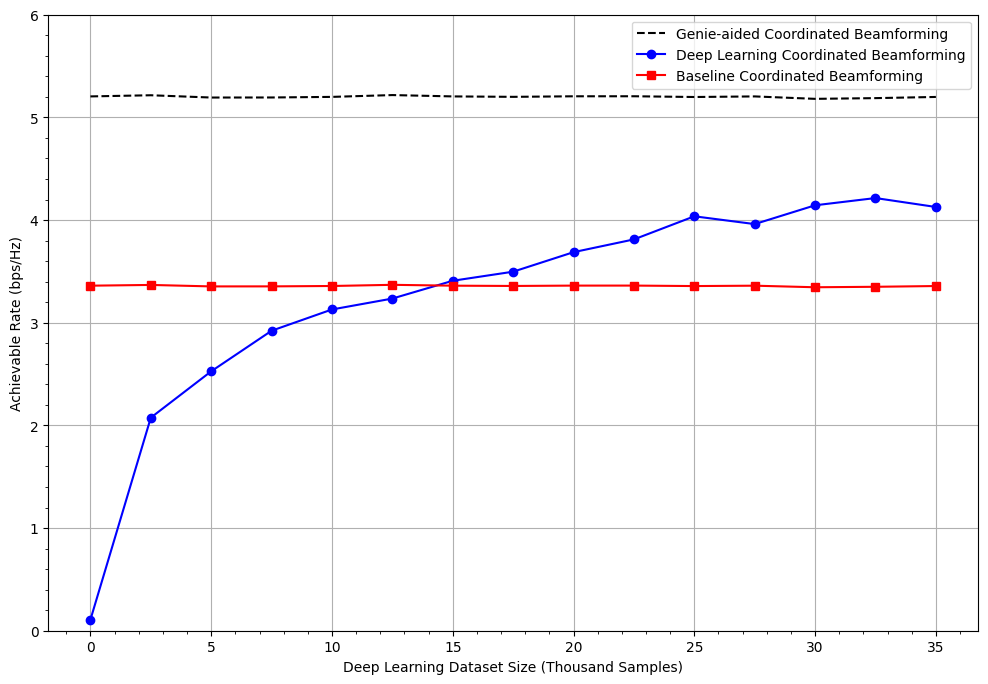

In [25]:
#%% Read Results
file_list = sorted(glob.glob('DLCB_code_output/DL_Result*'), key=lambda x: int(re.findall(r'\d+', x)[0]))
num_files = len(file_list)

user_index = []
pred_beams = []
opt_beams = []
for file in tqdm(file_list, desc='Reading DL results'):
    matfile = loadmat(file)
    l1 = []
    l2 = []
    for idx in range(num_bs):
        l1.append(matfile['TX'+str(idx+1)+'Pred_Beams'])
        l2.append(matfile['TX'+str(idx+1)+'Opt_Beams'])
        
    pred_beams.append(l1)
    opt_beams.append(l2)
    user_index.append(matfile['user_index'])


Pn = -204 + 10*np.log10(BW) # Noise power in dB
SNR = 10**(.1*(0-Pn))

ach_rate_DL = np.zeros(num_files)
ach_rate_opt = np.zeros(num_files)

eff_rate = np.zeros(num_files)
opt_rate = np.zeros(num_files)
for file_idx in tqdm(np.arange(num_files), desc = 'Calculating results'):
    user_index_file = user_index[file_idx].flatten()
    for ue_idx in range(len(user_index_file)):
        eff_ch = []
        opt_ch = []
        for bs_idx in range(num_bs):
            if file_idx == 0: # Random BF - 0 Samples
                pred_beam_idx = np.random.randint(num_beams)
            else:
                pred_beam_idx = np.argmax(pred_beams[file_idx][bs_idx][ue_idx])
            opt_beam_idx = np.argmax(opt_beams[file_idx][bs_idx][ue_idx])
            ch_single_bs = dataset[bs_idx]['user']['channel'][user_index_file[ue_idx]].squeeze()
            eff_ch_single_pred = ch_single_bs.T.conj() @ F[:, pred_beam_idx]
            opt_ch_single_pred = ch_single_bs.T.conj() @ F[:, opt_beam_idx]
            eff_ch.append(eff_ch_single_pred)
            opt_ch.append(opt_ch_single_pred)
        eff_ch = np.array(eff_ch)
        opt_ch = np.array(opt_ch)
        eff_rate[file_idx] += np.sum(np.log2(1 + SNR * np.abs(np.diag(eff_ch.conj().T @ eff_ch))))
        opt_rate[file_idx] += np.sum(np.log2(1 + SNR * np.abs(np.diag(opt_ch.conj().T @ opt_ch))))
    eff_rate[file_idx] /= len(user_index_file)*num_OFDM
    opt_rate[file_idx] /= len(user_index_file)*num_OFDM


# % Eff achievable rate calculations
theta_user=(102/parameters['bs_antenna'][0]['shape'][1])*np.pi/180
alpha=60*np.pi/180
distance_user=10
Tc_const=(distance_user*theta_user)/(2*np.sin(alpha)) # ms
Tt=10*1e-6; # ms

v_mph=50
v=v_mph*1000*1.6/3600 # m/s
Tc=Tc_const/v

overhead_opt=1-(num_beams*Tt)/Tc # overhead of beam training
overhead_DL=1-Tt/Tc # overhead of proposed DL method

#%% Plotting the figure
DL_size_array=np.arange(0, 2.5*(num_files), 2.5);

fig, ax = plt.subplots()
plt.plot(DL_size_array, opt_rate, '--k', label = 'Genie-aided Coordinated Beamforming')
plt.plot(DL_size_array, eff_rate*overhead_DL, '-bo', label = 'Deep Learning Coordinated Beamforming')
plt.plot(DL_size_array, opt_rate*overhead_opt, '-rs', label = 'Baseline Coordinated Beamforming')
plt.ylim([0, 6])
plt.minorticks_on()
plt.grid()
plt.xlabel('Deep Learning Dataset Size (Thousand Samples)')
plt.ylabel('Achievable Rate (bps/Hz)')
plt.legend()
plt.savefig('result.png')
